In [1]:
import os
import pickle 
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

['./camera_cal/calibration10.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration9.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration1.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration18.jpg']


 Calibration Images


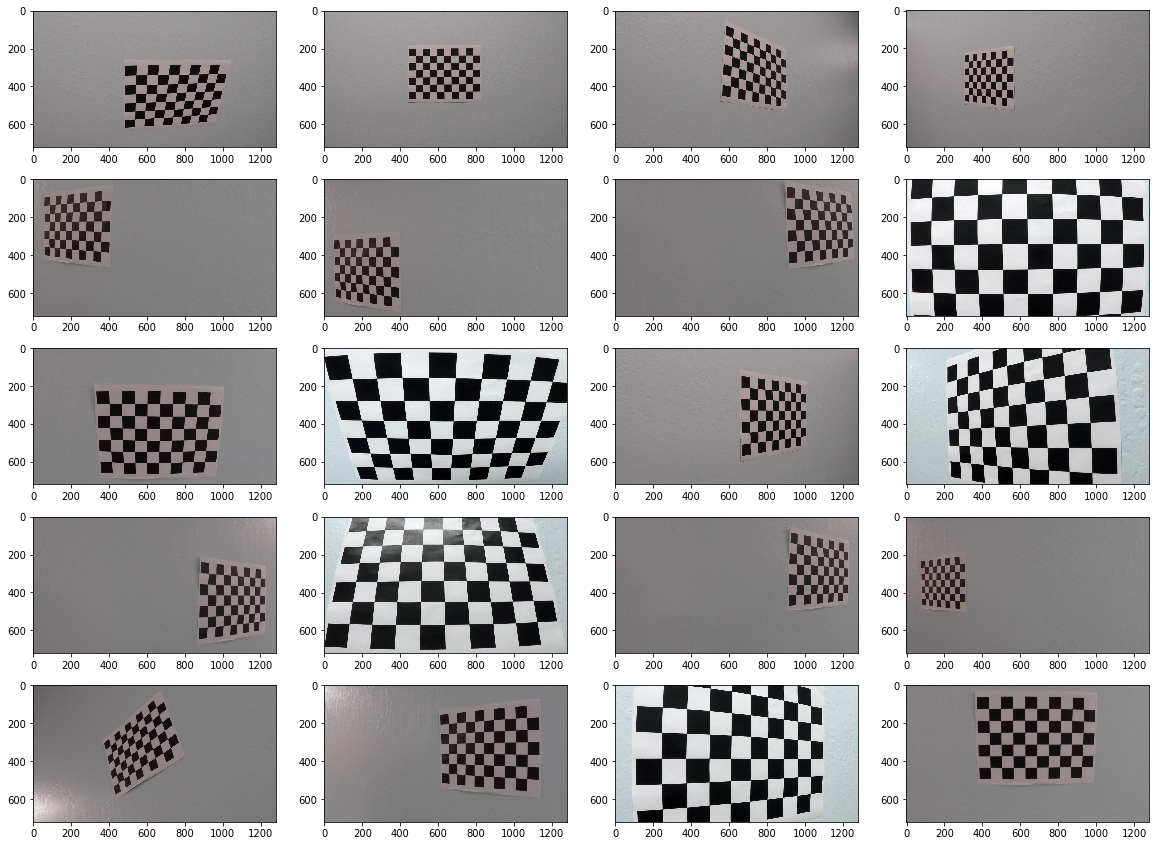

In [2]:
#DISPLAY IMAGE FILES FOR CALIBRATION
images = glob.glob('./camera_cal/calibration*.jpg')
print(images)

fig = plt.figure(figsize = (20,15))
print('\n\n Calibration Images')
for i, image_file in enumerate(images):
    sub = fig.add_subplot(5,4,i + 1)
    img = cv2.imread(image_file)
    sub.imshow(img)

In [3]:
#GET OBJECT AND IMGAE POINTS FOR CALIBRATION
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for image_file in images:
    img = mpimg.imread(image_file)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(nx, ny),None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

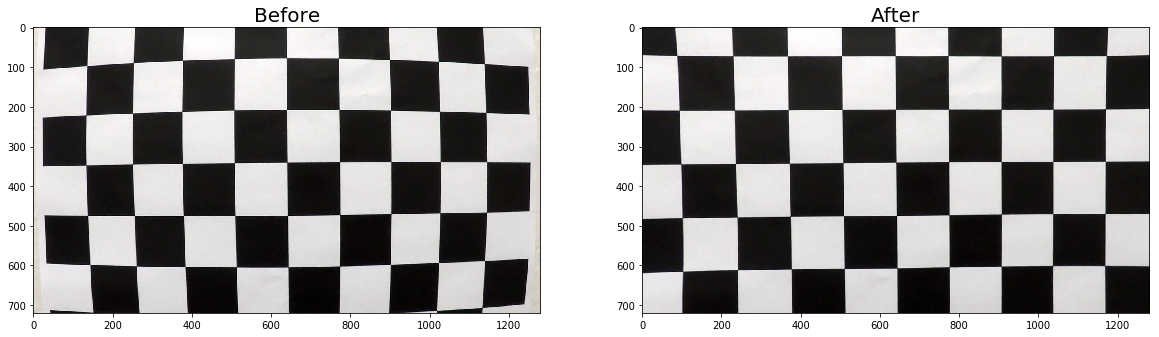

In [4]:
#UNDISTORT SAMPLE IMAGE
def convert_to_gray(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

def undistort(image, objpoints, imgpoints):
    gray = convert_to_gray(image)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    data = [mtx,dist]
    pickle.dump( data, open( "camera_calibration.pkl", "wb" ) )
    
    undistorted_image = cv2.undistort(image,mtx,dist,None,mtx)
    return undistorted_image

sample_image = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted_sample_image = undistort(sample_image, objpoints, imgpoints)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,15))
ax1.imshow(sample_image)
ax1.set_title('Before',fontsize=20)
ax2.imshow(undistorted_sample_image)
ax2.set_title('After',fontsize=20) 

for i, image_file in enumerate(images):
    ready_image = mpimg.imread(image_file)
    undistorted_image = undistort(ready_image, objpoints, imgpoints)
    

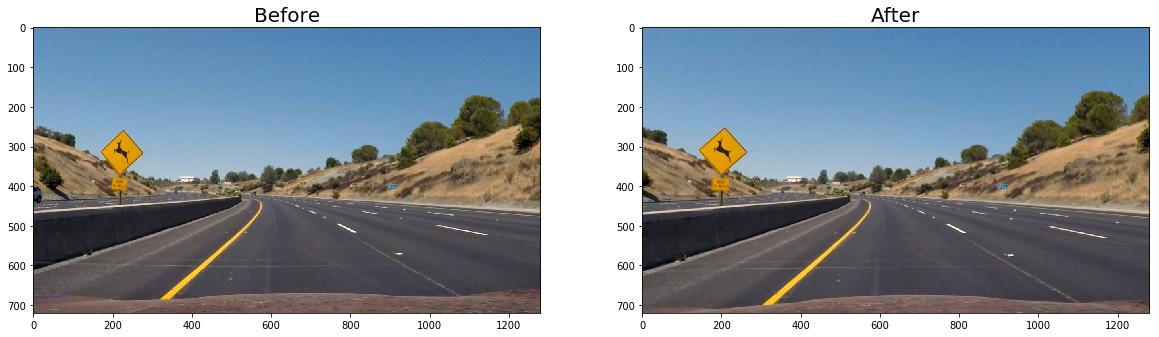

In [5]:
#UNDISTORT TEST IMAGE
test_image = mpimg.imread('./test_images/test2.jpg')
undistorted_test_image = undistort(test_image, objpoints, imgpoints)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,15))
ax1.imshow(test_image)
ax1.set_title('Before',fontsize=20)
ax2.imshow(undistorted_test_image)
ax2.set_title('After',fontsize=20) 

In [6]:
def transform_image(img,size,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped_image = cv2.warpPerspective(img,M,size,flags=cv2.INTER_LINEAR)
    return warped_image, M, Minv

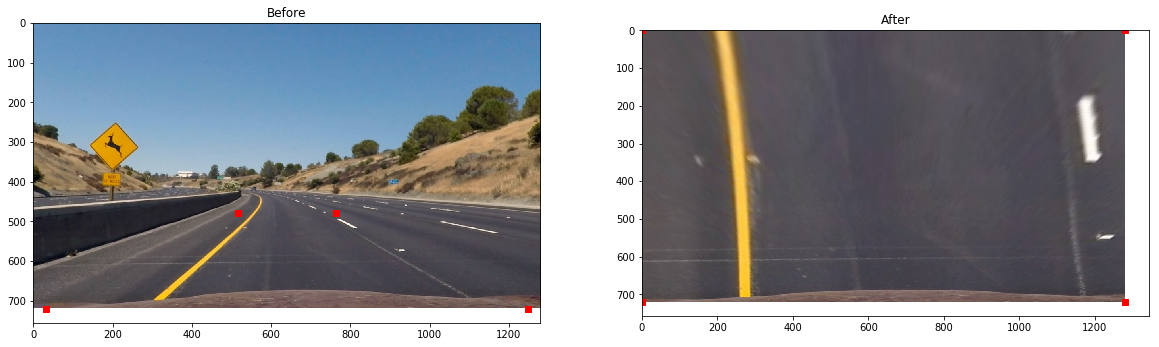

In [7]:
#APPLY PERSPECTIVE TRANSFORM
undistorted_test_image_size = np.shape(undistorted_test_image)
a = np.uint(undistorted_test_image_size[0]/1.5)
b = np.uint(undistorted_test_image_size[0])
area = np.uint(undistorted_test_image_size[1]/2)
a_area = area - .25*np.uint(undistorted_test_image_size[1]/2.6)
b_area = area + .25*np.uint(undistorted_test_image_size[1]/2.6)
c_area = area - .95*np.uint(undistorted_test_image_size[1]/2)
d_area = area + .95*np.uint(undistorted_test_image_size[1]/2)

src = np.float32([[c_area,b],[d_area,b],[b_area,a],[a_area,a]])

dst = np.float32([[0,undistorted_test_image_size[0]],[undistorted_test_image_size[1],undistorted_test_image_size[0]],
                  [undistorted_test_image_size[1],0],[0,0]])
warped_image, M, Minv = transform_image(undistorted_test_image, (undistorted_test_image_size[1],undistorted_test_image_size[0]), src, dst)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(undistorted_test_image)

for i in range(4):
    plt.plot(src[i][0],src[i][1], 'rs')
    
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(warped_image)

for i in range(4):
    plt.plot(dst[i][0],dst[i][1], 'rs')

plt.title('After')


In [8]:
def color_mask(img,low,high):
    mask = cv2.inRange(img,low,high)
    return mask
def masking_image(img,hsv,low,high):
    mask = cv2.inRange(hsv,low,high)
    masked = cv2.bitwise_and(img,img,mask=mask)
    return masked

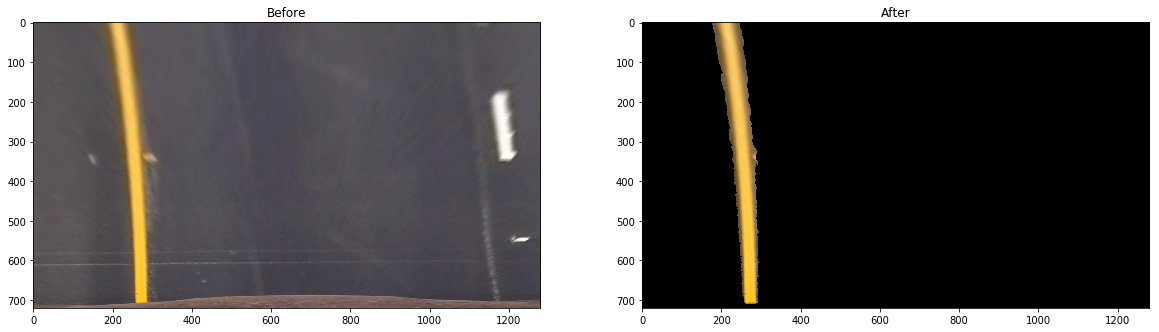

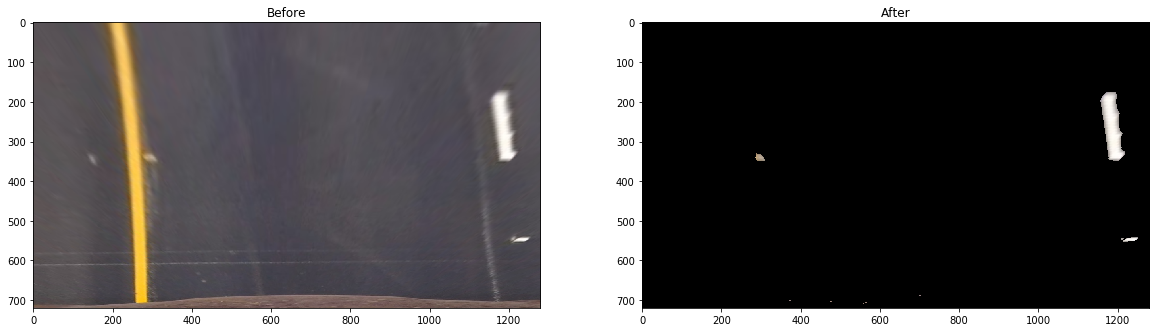

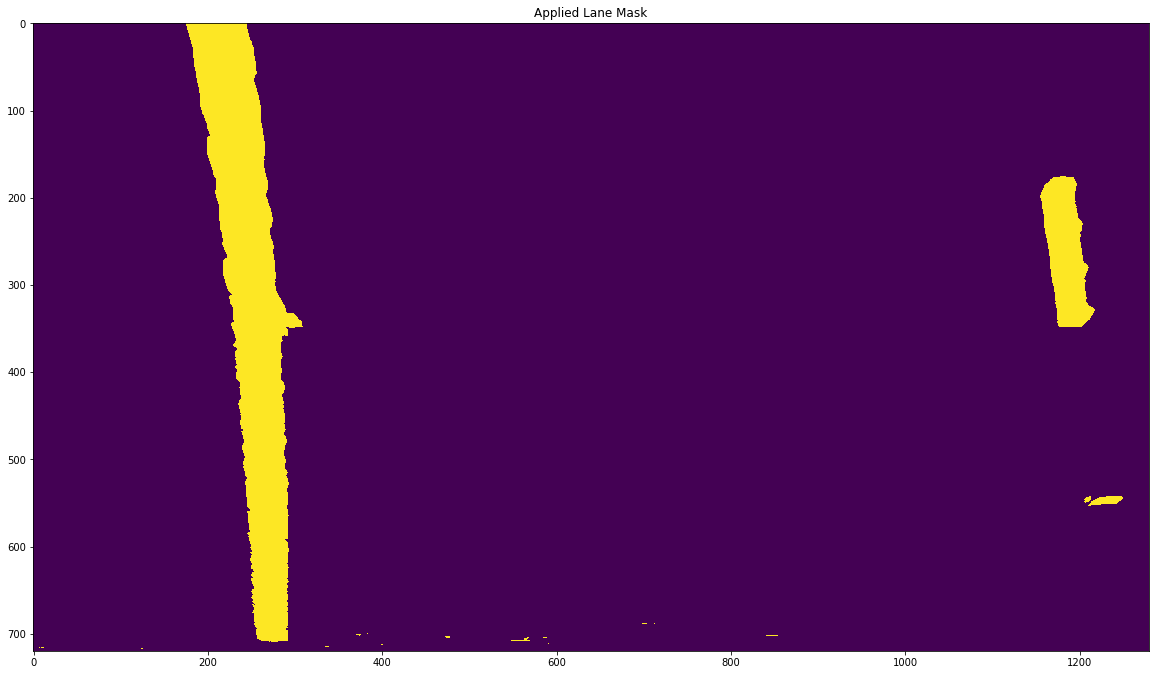

In [9]:
#APPLY COLOR MASK FOR LANE LINES
hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

yellow_hsv_high = np.array([100,255,255])
yellow_hsv_low = np.array([0,100,100])

color_mask_yellow = color_mask(hsv, yellow_hsv_low, yellow_hsv_high)
masked_yellow = masking_image(warped_image, hsv, yellow_hsv_low, yellow_hsv_high)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(warped_image)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(masked_yellow)
plt.title('After')

hsv = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HSV)

white_hsv_high = np.array([255,100,255])
white_hsv_low = np.array([0,0,150])

color_mask_white = color_mask(hsv, white_hsv_low, white_hsv_high)
masked_white = masking_image(warped_image, hsv, white_hsv_low, white_hsv_high)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(warped_image)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(masked_white)
plt.title('After')

masked_lane = cv2.bitwise_or(color_mask_yellow,color_mask_white)
plt.figure(figsize=(20,15))
plt.imshow(masked_lane)
plt.title('Applied Lane Mask')

In [10]:
def gaussian_blur(image,kernel=5):
    output = cv2.GaussianBlur(image,(kernel,kernel),0)
    return output
def magnitude(image,threshold=(0,255)):
    x = cv2.Sobel(image,cv2.CV_64F,1,0)
    y = cv2.Sobel(image,cv2.CV_64F,0,1)
    s = np.sqrt(x**2 + y**2)
    s = np.uint8(s * 255 / np.max(s))
    s = np.uint8(s*255/np.max(s))
    output = 0 * s
    output[(s >= threshold[0]) & (s <= threshold[1])] = 1
    return output
def threshold(image,skernel=3,threshold=(0,np.pi/2)):
    x = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=skernel)
    y = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=skernel)
    s = np.arctan2(np.absolute(y), np.absolute(x))
    output = 0 * s
    output[(s >= threshold[0]) & (s <= threshold[1])] = 1
    return output
def abs_sobel(image,orientation='x',threshold=(50,200)):
    if orientation == 'x':
        s = cv2.Sobel(image,cv2.CV_64F,1,0)
    if orientation == 'y':
        s = cv2.Sobel(image,cv2.CV_64F,0,1)
    abs_image = np.absolute(s)
    sobel_image = np.uint8(255 * abs_image / np.max(abs_image))
    output = 0 * sobel_image
    output[(sobel_image >= threshold[0]) & (sobel_image <= threshold[1])] = 1
    return output
def sobel(image):
    a = magnitude(image,(20,150))
    b = threshold(image,3,(.6,1.1))
    x = abs_sobel(image,'x',(50,200))
    y = abs_sobel(image,'y',(50,200))
    output = np.zeros_like(b)
    output[((x == 1) & (y == 1)) | ((a == 1) & (b == 1))] = 1
    return output 

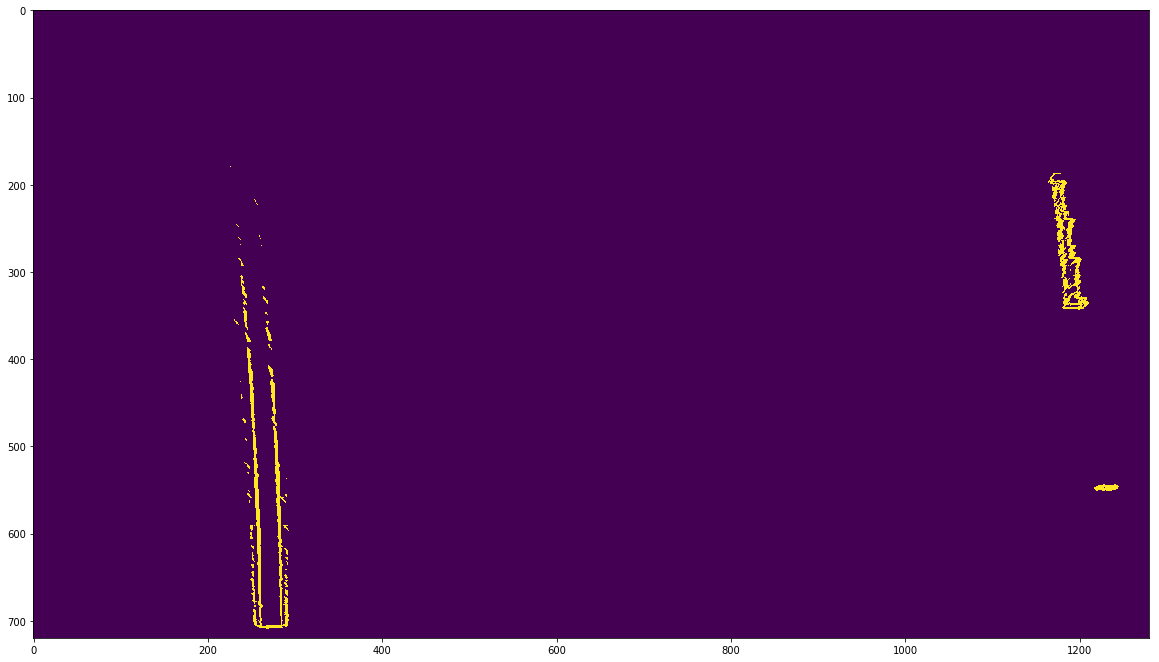

In [11]:
#SEPARATE S FROM HLS COLOR SPACE 
hls = cv2.cvtColor(warped_image,cv2.COLOR_RGB2HLS)
channeled_image = hls[:,:,2]
sobel_c = sobel(channeled_image)
abs_x = abs_sobel(channeled_image,'x',(50,255))
abs_y = abs_sobel(channeled_image,'y',(50,255))

combined_warp = np.copy(cv2.bitwise_or(abs_x,abs_y))
plt.figure(figsize=(20,15))
plt.imshow(combined_warp)

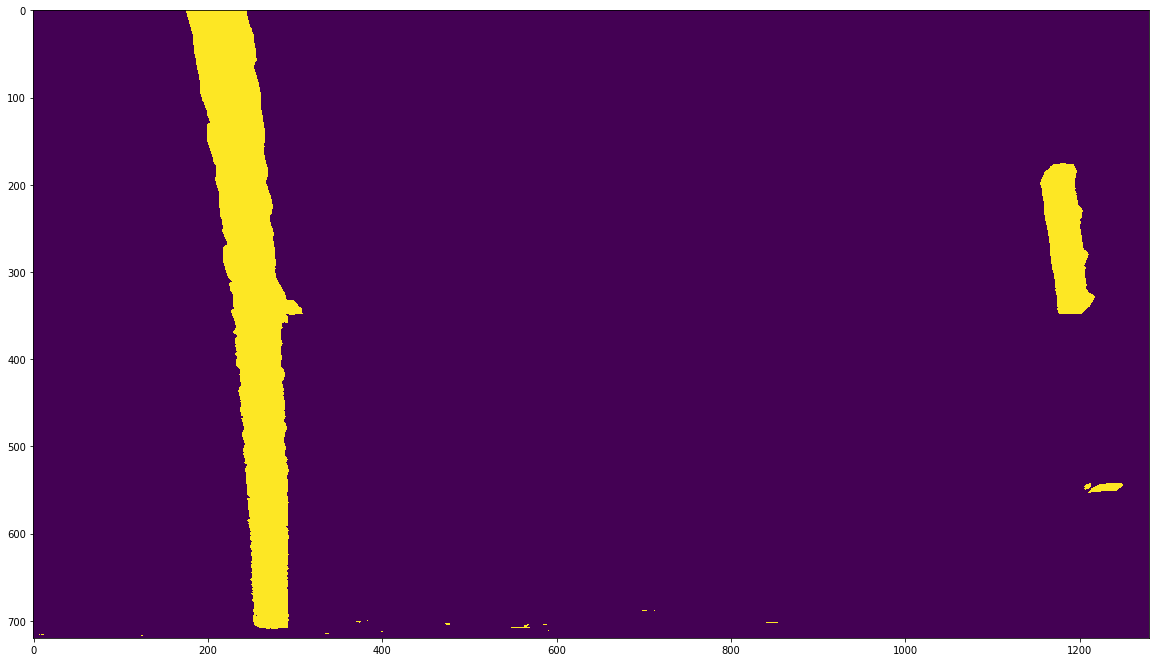

In [12]:
#COLOR MASK AND SOBEL COMBINED
combined_image = np.zeros_like(combined_warp)
combined_image[(masked_lane >= .5) | (combined_warp >= .5)] = 1

plt.figure(figsize=(20,15))
plt.imshow(gaussian_blur(combined_image,1))

In [13]:
def calc_avg(a, n=3):
    # Moving average
    x = np.cumsum(a, dtype=float)
    x[n:] = x[n:] - x[:-n]
    return x[n - 1:] / n

In [14]:
box = undistorted_test_image_size[1]/50.
mean = np.mean(combined_image[undistorted_test_image_size[0]//2:,:],axis=0)
mean = calc_avg(mean,box)

In [15]:
points = find_peaks_cwt(mean,[100], max_distances=[800])
window=50
q = np.array([mean[points[i]] for i in range(len(points)) ])
w = np.argsort(-q)

left_peak = points[w[1]]
right_peak = points[w[0]]

if right_peak<left_peak:
    temp = right_peak
    right_peak = left_peak
    left_peak = temp

left_lane_mask = np.zeros_like(combined_image)
right_lane_maks = np.zeros_like(combined_image)
print(left_peak,right_peak)

255 1217


In [17]:
old_right_peak = right_peak
old_left_peak = left_peak

for i in range(8):
    t = undistorted_test_image_size[0]-undistorted_test_image_size[0]*i/8
    y = undistorted_test_image_size[0]-undistorted_test_image_size[0]*(i+1)/8
    t_mean = np.mean(combined_image[y:t,:],axis=0)
    t_mean = calc_avg(t_mean,box)
    points = find_peaks_cwt(t_mean,[100], max_distances=[800])
    
    if len(points)>1.5:
        q = np.array([mean[points[i]] for i in range(len(points)) ])
        w = np.argsort(-q)

        right_peak = points[w[0]]
        left_peak = points[w[1]]
        if right_peak<left_peak:
            temp = right_peak
            right_peak = left_peak
            left_peak = temp
            
    else:
        if len(points)==1:
            if np.abs(points[0]-old_right_peak)<np.abs(points[0]-old_left_peak):
                right_peak = points[0]
                left_peak = old_left_peak
            else:
                left_peak = points[0]
                right_peak = old_right_peak
        else:
            left_peak = old_left_peak
            right_peak = old_right_peak
                
    if np.abs(left_peak-old_left_peak)>=100:
        left_peak = old_left_peak
    if np.abs(right_peak-old_right_peak)>=100:
        right_peak = old_right_peak
     
    left_lane_mask[y:t,left_peak-window:left_peak+window] = 1.     
    right_lane_maks[y:t,right_peak-window:right_peak+window] = 1. 
    old_left_peak = left_peak
    old_right_peak = right_peak

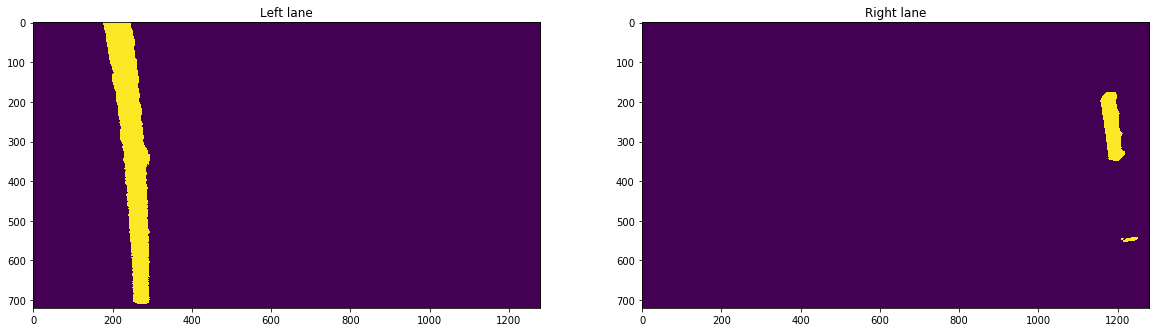

In [18]:
left_mask = left_lane_mask
image_left = np.copy(combined_image)
image_left = cv2.bitwise_and(image_left,image_left,mask=left_lane_mask)

right_mask = right_lane_maks
image_right = np.copy(combined_image)
image_right = cv2.bitwise_and(image_right,image_right,mask=right_lane_maks)

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.title('Left lane')
plt.imshow(image_left)
plt.subplot(1,2,2)
plt.title('Right lane')
plt.imshow(image_right)